In [1]:
import time
start_time = time.time()
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from surprise import Dataset,Reader, SVD, KNNWithMeans, accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 400)

In [2]:
path = os.getcwd()
filenames = glob.glob(path + "\Data Set\*.csv")
temp = []
for filename in filenames:
    temp.append(pd.read_csv(filename,encoding = 'latin-1'))
df = pd.concat(temp)
df.reset_index(inplace = True, drop = True)
df

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,"As a diehard Samsung fan who has had every Samsung phone since before the S series started, this has been my favorite upgrade so far. I am amazed at some of the reviews and think people may just have a defective device that needs to be replaced. The battery life is amazing.",CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth and beautiful I highly recommend the phone you will not regret getting this phone.,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sluggish for the few apps that I have installed. Samsung wants to vacuum all of your data with their apps that requires more access than needed. What else is new.,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unlocked (GSM + CDMA, US WARRANTY) (Orchid Gray)"
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,"Never disappointed. One of the reasons I've been a long Samsung (product) consumer, they're ability to impress me with each product release. I've owned, or maintained, all Samsung smartphones starting with the S4 and the S8 is the best one yet.",Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people that have carried their phone in their pocket without problems until the S8. Day one screen has crack from being in my pocket. Bluetooth on my 1st trip struggles to stay connected. Good news.....battery life is great and lots of great features.,S Ate Mine,Samsung Galaxy S8
...,...,...,...,...,...,...,...,...,...,...,...
1415128,/cellphones/alcatel-ot-club_1187/,5/12/2000,de,de,Ciao,ciao.de,2.0,10.0,"Weil mein Onkel bei ALcatel arbeitet habe ich ihn natÃ¼rlich auch einmal gefragt, was fÃ¼r ein Handy er hat. Darauf bekam ich die Antwort: ""Ein SIEMENS-Handy"". Das ist natÃ¼rlich schon ein bisschen komisch, finde ich zumindest.",david.paul,Alcatel Club Plus Handy
1415129,/cellphones/alcatel-ot-club_1187/,5/11/2000,de,de,Ciao,ciao.de,10.0,10.0,Hy Liebe Leserinnen und Leser!! Ich habe seit ein paar Monaten ein Alcatel!! Und ich finde es nicht schlecht die TÃ¶ne sind auch recht gut und man muss sich ja nicht so ein teures kaufen es reicht das genauso!!! Ich finde die Tasten eignen sich gut zum sms schreiben und sind auch so recht ok!!,Christiane14,Alcatel Club Plus Handy
1415130,/cellphones/alcatel-ot-club_1187/,5/4/2000,de,de,Ciao,ciao.de,2.0,10.0,"Jetzt hat wohl Alcatell gedacht ,sie machen was super gutes.Aber auch dieses Mal hat es nicht geklappt. Dieses Handy ist zwar auch ein Dual-Band-Handy,aber das ist auch das einzig gute daran.Von der Form ist es fÃ¼rchterlich anzusehen und auch von schwarz auf silber hat keine groÃe VerÃ¤nderung...",michaelawr,Alcatel Club Plus Handy
1415131,/cellphones/alcatel-ot-club_1187/,5/1/2000,de,de,Ciao,ciao.de,8.0,10.0,"Ich bin seit 2 Jahren (stolzer) Besitzer eines alcatel one touch club+. Im Grossen und Ganzen bin ich echt zufrieden.....einfache MenÃ¼fÃ¼hrung, keine sinnlosen Spielerein (tetris...) und - was mich persÃ¶nlich am meisten beeindruckt - Ã¤uÃerst stabil.",claudia0815,Alcatel Club Plus Handy


In [3]:
df_info = pd.DataFrame(columns=['Type','NaN', '%'])
for c in df.columns:
    df_info.loc[c, 'Type'] = df[c].dtype
    df_info.loc[c, 'NaN'] = df[c].isnull().sum()
    df_info.loc[c, '%'] = df[c].isnull().sum()/df.shape[0]
df_info

,Type,NaN,%
phone_url,object,0,0.0
date,object,0,0.0
lang,object,0,0.0
country,object,0,0.0
source,object,0,0.0
domain,object,0,0.0
score,float64,63489,0.044864
score_max,float64,63489,0.044864
extract,object,19361,0.013681
author,object,63202,0.044662


In [4]:
df.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
score,1351644.0,8.00706,2.616121,0.2,7.2,9.2,10.0,10.0
score_max,1351644.0,10.00000,0.000000,10.0,10.0,10.0,10.0,10.0


In [5]:
df['score'] = df['score'].round()
df['score_max'] = df['score_max'].round()

In [6]:
null_col = []
for c in df.columns:
    if df[c].isnull().any()==True:
        null_col.append(c)
        
print("Columns with null/empty values:", null_col)

delete_cols = []

Columns with null/empty values: ['score', 'score_max', 'extract', 'author', 'product']


In [7]:
df['phone_url'] = df['phone_url'].str.split('/').str[-2].str.replace('-', ' ')
df['product'] = df['phone_url']
df['score'] = df.groupby(['phone_url','country'])['score'].transform(lambda grp: grp.fillna(np.median(grp))).round()
df['score'] = df['score'].fillna(df['score'].median()).round()

df.dropna(inplace=True)

# df['score_max'] = df.groupby(['phone_url','country'])['score_max'].transform(lambda grp: grp.fillna(np.median(grp))).round()

In [8]:
print('Number of duplicate rows:',df.duplicated().sum())
duplicate = df[df.duplicated()]
df.drop_duplicates(inplace=True)
duplicate.head(10)

Number of duplicate rows: 15105


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
241,samsung galaxy s8,5/9/2017,fi,fi,Verkkokauppa,verkkokauppa.com,10.0,10.0,Plussaa: +Todella sulava kokemus arkikÃ¤ytÃ¶ssÃ¤ ilman tÃ¶kkimisiÃ¤ +Akku kestÃ¤Ã¤ kokopÃ¤ivÃ¤n vaikka pelaisikin paljon +Kamera Miinusta: -Bixby ja sen paikine -> Google assistant korvaa ja sovellus joka antaa remapata kyseisen napin -Ei stereo kaiutinta -Hinta MikÃ¤li hinta ei tunnu liian suolaiselta niin...,Kaksdee,samsung galaxy s8
256,samsung galaxy s8,5/5/2017,fi,fi,Verkkokauppa,verkkokauppa.com,8.0,10.0,"Siirryin s6 edgestÃ¤ tÃ¤hÃ¤n s8:iin. MitÃ¤Ã¤n ylivoimaisen maata mullistavaa uudistusta ei s8 tarjoa vanhaan malliin nÃ¤hden. NÃ¤yttÃ¶ on hyvÃ¤ ja iso. NÃ¤yttÃ¶Ã¶n piilotettu ""pÃ¤Ã¤nÃ¤ppÃ¤in"" ei ole niin kÃ¤tevÃ¤ kuin vanhanaikainen (ainakaan alkuun).",Jator78,samsung galaxy s8
342,samsung galaxy s8,4/26/2017,nl,nl,Coolblue,coolblue.nl,10.0,10.0,"Ik vind het tot nu toe een heel erg aangenaam toestel. Licht in de hand, zeer goede kwaliteit van beeld, scherm en camera. Ook snelheid en geheugen opsla is geweldig. Enkel het toetsenbord is minder gebruiksvriendelijk.",Stefanie Hinneman,samsung galaxy s8
343,samsung galaxy s8,4/26/2017,nl,nl,Coolblue,coolblue.nl,10.0,10.0,"Ik vind het tot nu toe een heel erg aangenaam toestel. Licht in de hand, zeer goede kwaliteit van beeld, scherm en camera. Ook snelheid en geheugen opsla is geweldig. Enkel het toetsenbord is minder gebruiksvriendelijk.",Stefanie Hinneman,samsung galaxy s8
371,samsung galaxy s8,4/25/2017,nl,nl,Coolblue,coolblue.nl,10.0,10.0,Tot nu toe in de eerste dagen weinig tot geen minpunten aan te geven.,Robin Winckens,samsung galaxy s8
452,samsung galaxy s8,4/25/2017,nl,nl,Coolblue,coolblue.nl,10.0,10.0,Wat een huge scherm!,B Yapar,samsung galaxy s8
462,samsung galaxy s8,4/24/2017,fi,fi,Verkkokauppa,verkkokauppa.com,10.0,10.0,HyvÃ¤ puhelin. Helppo kÃ¤yttÃ¤Ã¤. NÃ¤yttÃ¤Ã¤ hyvÃ¤ltÃ¤ ja on kÃ¤ytÃ¤nnÃ¶llinen puhelin.,Artsi2017,samsung galaxy s8
469,samsung galaxy s8,4/23/2017,fi,fi,Verkkokauppa,verkkokauppa.com,2.0,10.0,"Miinusta: - Chrome selain tÃ¶kkii todella paljon - Surkee akunkesto - Todella hankala TouchID - Koko puhelin tuntuu todella hitaalta ja tÃ¶kkivÃ¤ltÃ¤ - Hello Bixby kortit ei toimi kunnolla - Kuvakkeiden ""badget"" bugailee pahasti TÃ¤stÃ¤ puhelimesta ei ole ainuttakaan hyvÃ¤Ã¤ asiaa sanottavana.",Toni Kumpula,samsung galaxy s8
482,samsung galaxy s8,4/21/2017,fi,fi,Verkkokauppa,verkkokauppa.com,10.0,10.0,"No kyllÃ¤ se taas on. Aina malli mallilta kauniinpi,nopeampi ja Ã¤lykkÃ¤Ã¤mpi. Mutta on se sen arvoinen siiinÃ¤ on kuitenkin kaikki mitÃ¤ odotta vielÃ¤ taskuun mahtuvalta ""supertietokoneesta"".",Android fani,samsung galaxy s8
2869,samsung galaxy s6 edgeplus,11/22/2015,en,us,Samsung,samsung.com,10.0,10.0,LOVE EVERYTHING ABOUT THIS PHONE!!!!!!!!!!!!!!!!!!,heyitsmecris,samsung galaxy s6 edgeplus


In [9]:
df1 = df.sample(n = 1000000, random_state = 612)
df1.shape

(1000000, 11)

In [10]:
del_cols = ['phone_url','date','lang','country', 'source','domain','score_max', 'extract']
df1.drop(del_cols, axis=1, inplace=True)
df1.columns

Index(['score', 'author', 'product'], dtype='object')

In [11]:
s1 = pd.DataFrame(df1.groupby(['product'])['score'].count().sort_values(ascending=False))
s1.head(10)

,score
product,
samsung galaxy s6,12517
samsung galaxy s7 edge,12265
apple iphone 5s,11790
samsung galaxy s5,11617
motorola moto g,11384
samsung galaxy s iii,10868
samsung galaxy s7 789999,10389
huawei p8 lite,9777
samsung i9500 galaxy s iv,9702


In [12]:
s2 = pd.DataFrame(df1.groupby(['author'])['score'].count().sort_values(ascending=False))
s2.head(10)

,score
author,
Amazon Customer,60851
Cliente Amazon,15253
e-bit,6695
Client d'Amazon,6153
Amazon Kunde,3754
einer Kundin,2092
Anonymous,2028
einem Kunden,1547
unknown,1353


Shape after pre-processing: (1000000, 3)

Total no. of ratings : 1000000
Total no. of Users   : 630755
Total no. of products  : 5466
----------------------------------------------------------------------------------------------------
Shape after selecting records with >50 ratings: (951260, 3)

Total no. of ratings : 951260
Total no. of Users   : 600316
Total no. of products  : 2237


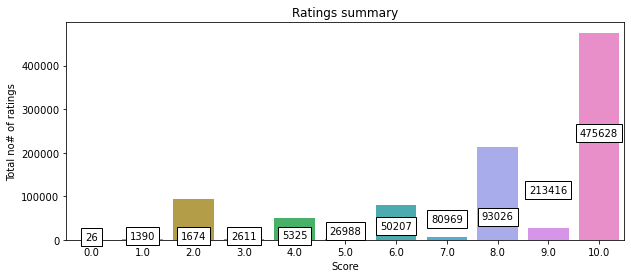

In [13]:
product_list = s1.index[s1['score']>=50]
product_list.append(s2.index[s2['score']>=50])
product_list = set(product_list)

print('Shape after pre-processing:',df1.shape)
print('\nTotal no. of ratings :',df1.shape[0])
print('Total no. of Users   :', df1['author'].nunique())
print('Total no. of products  :', df1['product'].nunique())
df1 = df1.loc[df1['product'].isin(product_list)]
print('-'*100)

print('Shape after selecting records with >50 ratings:',df1.shape)
print('\nTotal no. of ratings :',df1.shape[0])
print('Total no. of Users   :', df1['author'].nunique())
print('Total no. of products  :', df1['product'].nunique())

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2,y[i], ha = 'center', Bbox = dict(facecolor = 'white'))

plt.figure(figsize=(10,4))
ratings = df1['score'].value_counts().sort_values(ascending=True)
sns.barplot(x=ratings.index, y=ratings.values)
addlabels(ratings.index, ratings.values)
plt.title('Ratings summary')
plt.ylabel('Total no# of ratings')
plt.xlabel('Score')
plt.show()



In [14]:
train_data_grouped = df1.groupby('product').agg({'author': 'count'}).reset_index()
train_data_grouped.rename(columns = {'author': 'score'},inplace=True)
train_data_sort = train_data_grouped.sort_values(['score', 'product'], ascending = [0,1]) 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,product,score,Rank
1670,samsung galaxy s6,12517,1.0
1676,samsung galaxy s7 edge,12265,2.0
78,apple iphone 5s,11790,3.0
1666,samsung galaxy s5,11617,4.0
995,motorola moto g,11384,5.0


In [15]:
df2 = df1.sample(n = 12000, random_state = 612)
min_scale = df2.score.min()
max_scale = df2.score.max()

reader = Reader(rating_scale=(min_scale, max_scale))

data = Dataset.load_from_df(df2[['author', 'product', 'score']], reader)

trainset, testset = train_test_split(data, test_size=0.2,random_state=10)

pred_list = []

Considering memory limitations caused by the large sized data, the dataset is reduced to 12000 samples for further processing.

#### SVD

In [16]:
svd_model = SVD(n_factors=5,biased=False)
svd_model.fit(trainset)

svd_test_pred = svd_model.test(testset)

# print('\nSVD RMSE\n')
svd_test_rmse = accuracy.rmse(svd_test_pred, verbose=False)
result = pd.DataFrame({'Model' : ['SVD'], 
                       'RMSE' : [svd_test_rmse]}) 


df_cv = pd.DataFrame({'Model' : ['SVD'], 
                      'RMSE' : [svd_test_rmse],
                      'MAE': [''],
                      'Fit Time': [''],
                      'Test Time' : ['']})  

pred_list.append(svd_test_pred)

#### kNNWithMeans item-based model

In [17]:
knn_ib_model = KNNWithMeans(k=10, sim_options={ 'user_based': False})

knn_ib_model.fit(trainset)
knnmib_test_pred=knn_ib_model.test(testset)
# print('\nKNNMeans RMSE Item based\n')
knnmib_test_rmse = accuracy.rmse(knnmib_test_pred, verbose=False)
result.loc[1] = ['KNNMeans Item based', knnmib_test_rmse]

df_cv.loc[1] = ['KNNMeans Item Based', 
                knnmib_test_rmse, 
                '', '','']
pred_list.append(knnmib_test_pred)

Computing the msd similarity matrix...
Done computing similarity matrix.


#### kNNWithMeans user-based model

In [18]:
knn_ub_model = KNNWithMeans(k=10, sim_options={ 'user_based': True})
knn_ub_model.fit(trainset)
knnmub_test_pred=knn_ub_model.test(testset)
# print('\nKNNMeans RMSE User based\n')
knnmub_test_rmse = accuracy.rmse(knnmub_test_pred, verbose=False)
result.loc[2] = ['KNNMeans User based', knnmub_test_rmse]
df_cv.loc[2] = ['KNNMeans User Based', 
                knnmub_test_rmse, 
                '', '','']
pred_list.append(knnmub_test_pred)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [19]:
result[result.columns[[0,1]]]

,Model,RMSE
0,SVD,3.263577
1,KNNMeans Item based,2.683219
2,KNNMeans User based,2.701043


In [20]:
print('Overall best model for recommendation systems is:')
result[result['RMSE']==result['RMSE'].min()]

Overall best model for recommendation systems is:


,Model,RMSE
1,KNNMeans Item based,2.683219


In [21]:
n = 0
was_imp = 0
total = len(pred_list[0])
pred_index = result[result['RMSE']==result['RMSE'].min()].index[0]

df_temp = pd.DataFrame(columns=['User','Product','Score'])
# for pred in pred_list[pred_index]
for pred in pred_list[0]:
    pred_val = list(pred)
    was_impossible = list(pred_val[4].keys())[0]
    if(pred_val[4][was_impossible] == False):
        df_temp.loc[n] = [pred[0],pred[1],pred[2]]
        n +=1
    else:
        was_imp += 1

print('Total predictions:', total)
print('Number of predictions with was_impossible=True', was_imp )
print('Number of predictions with was_impossible=False', total -was_imp )
print('Predicted score for', result['Model'][0],':')
df_temp

Total predictions: 2400
Number of predictions with was_impossible=True 2006
Number of predictions with was_impossible=False 394
Predicted score for SVD :


,User,Product,Score
0,Thomas,huawei p8 lite 2017,10.0
1,Amazon Customer,vodafone smart ultra 6,10.0
2,Andy,nokia 225,8.0
3,Cliente Amazon,microsoft lumia 950,8.0
4,jose,motorola moto g,10.0
...,...,...,...
389,Amazon Customer,xiaomi mi max,10.0
390,Cliente Amazon,huawei y6,10.0
391,Marco,samsung s5611,10.0
392,Amazon Customer,lenovo a7000,2.0


In [22]:
n = 0
was_imp = 0
total = len(pred_list[1])
df_temp = pd.DataFrame(columns=['User','Product','Score'])
for pred in pred_list[1]:
    pred_val = list(pred)
    was_impossible = list(pred_val[4].keys())[0]
    if(pred_val[4][was_impossible] == False):
        df_temp.loc[n] = [pred[0],pred[1],pred[2]]
        n +=1
    else:
        was_imp += 1        
print('Total predictions:', total)
print('Number of predictions with was_impossible=True', was_imp )
print('Number of predictions with was_impossible=False', total -was_imp )
print('Predicted score for', result['Model'][1],':')        
df_temp

Total predictions: 2400
Number of predictions with was_impossible=True 2253
Number of predictions with was_impossible=False 147
Predicted score for KNNMeans Item based :


,User,Product,Score
0,Thomas,huawei p8 lite 2017,10.0
1,Andy,nokia 225,8.0
2,Phil,samsung u800 soul,8.0
3,Simon,sony ericsson xperia x1,10.0
4,Domenico,nokia 105,8.0
...,...,...,...
142,Terry,htc droid incredible 2,4.0
143,Video Italia Review,lg g6,8.0
144,Robert,nokia lumia 635,10.0
145,Amazon Customer,sony xperia x f5121,10.0


In [23]:
n = 0
was_imp = 0
total = len(pred_list[2])
pred_index = result[result['RMSE']==result['RMSE'].min()].index[0]

df_temp = pd.DataFrame(columns=['User','Product','Score'])
for pred in pred_list[2]:
    pred_val = list(pred)
    was_impossible = list(pred_val[4].keys())[0]
    if(pred_val[4][was_impossible] == False):
        df_temp.loc[n] = [pred[0],pred[1],pred[2]]
        n +=1
    else:
        was_imp += 1        
print('Total predictions:', total)
print('Number of predictions with was_impossible=True', was_imp )
print('Number of predictions with was_impossible=False', total -was_imp )
print('Predicted score for', result['Model'][2],':')       
df_temp

Total predictions: 2400
Number of predictions with was_impossible=True 2253
Number of predictions with was_impossible=False 147
Predicted score for KNNMeans User based :


,User,Product,Score
0,Thomas,huawei p8 lite 2017,10.0
1,Andy,nokia 225,8.0
2,Phil,samsung u800 soul,8.0
3,Simon,sony ericsson xperia x1,10.0
4,Domenico,nokia 105,8.0
...,...,...,...
142,Terry,htc droid incredible 2,4.0
143,Video Italia Review,lg g6,8.0
144,Robert,nokia lumia 635,10.0
145,Amazon Customer,sony xperia x f5121,10.0


- 

In [24]:
def get_top_n(predictions, n):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [25]:
top_n = get_top_n(svd_test_pred, n=5)
rec_df = pd.DataFrame([],columns=['User','Products','Top-n Count'])
i = 0
for uid, user_ratings in top_n.items():
    a = uid
    b = [iid for (iid, _) in list(set(user_ratings))]
    c = len(b)
    b =  ','.join([str(x) for x in b])
    rec_df.loc[i] = [a,b,c]
    i +=1

    
print('Total number of predicted users in testing set:',len(top_n))
print('Top-n products for test users using SVD: ')
rec_df[rec_df['Top-n Count']>=2].sort_values(by = 'Top-n Count', ascending=False)

Total number of predicted users in testing set: 2133
Top-n products for test users using SVD: 


,User,Products,Top-n Count
10,Cliente Amazon,"sony xperia z3 compact,huawei honor 7,samsung galaxy j7 2016,lg g4,samsung galaxy j5 4g lte 5 2 inches",5
49,Amazon Kunde,"huawei honor 7,samsung galaxy a5 2016,huawei honor 8,microsoft lumia 640 dual sim,samsung galaxy s6",5
5,Amazon Customer,"nokia lumia 520,samsung galaxy note 2,sony xperia z5,microsoft lumia 640 dual sim,lg google nexus 5",5
417,Jorge,"nokia 108,lg optimus l5 e610,sony ericsson w900i,lg g3 d855 657484",4
35,Simon,"samsung gt e1200,sony ericsson xperia x1,archos 50 helium,acer cloudmobile",4
70,Anonymous,"samsung galaxy s7 789999,samsung galaxy s6,samsung galaxy s7 edge,samsung galaxy s blaze",4
162,Client d'Amazon,"huawei honor 6x,huawei p8 lite,samsung i9500 galaxy s iv,samsung galaxy j3 duos",4
259,einer Kundin,"lg stylus 2,huawei p9 lite,samsung galaxy a3 2016,samsung galaxy a3 819970",4
423,e-bit,"asus ze550kl,samsung galaxy j1 2016 4 5 sm j120,samsung galaxy grand prime,nokia lumia 530",4
478,unknown,"sony xperia xa,apple iphone 7,lg g4",3


In [26]:
top_n = get_top_n(knnmub_test_pred, n=5)
rec_df = pd.DataFrame([],columns=['User','Products','Top-n Count'])
i = 0
for uid, user_ratings in top_n.items():
    a = uid
    b = [iid for (iid, _) in list(set(user_ratings))]
    c = len(b)
    b =  ','.join([str(x) for x in b])
    rec_df.loc[i] = [a,b,c]
    i +=1

    
print('Total number of predicted users in testing set:',len(top_n))
print('Top-n products for test users using KNNMeans Userbased: ')
rec_df[rec_df['Top-n Count']>=2].sort_values(by = 'Top-n Count', ascending=False)

Total number of predicted users in testing set: 2133
Top-n products for test users using KNNMeans Userbased: 


,User,Products,Top-n Count
10,Cliente Amazon,"sony xperia z3 compact,huawei p9 797082,asus zenfone 3 max,samsung galaxy note iii,huawei honor 7",5
49,Amazon Kunde,"huawei honor 7,huawei honor 8,huawei g8,microsoft lumia 640 dual sim,samsung galaxy s6",5
162,Client d'Amazon,"samsung galaxy core plus,apple iphone 5s,huawei p8 lite,huawei honor 6x,samsung galaxy grand prime",5
417,Jorge,"nokia 108,lg optimus l5 e610,sony ericsson w900i,lg g3 d855 657484",4
35,Simon,"acer cloudmobile,samsung gt e1200,archos 50 helium,sony ericsson xperia x1",4
70,Anonymous,"samsung galaxy s7 edge,samsung galaxy s blaze,samsung galaxy s7 789999,samsung galaxy s6",4
259,einer Kundin,"huawei p9 lite,lg stylus 2,samsung galaxy a3 819970,samsung galaxy a3 2016",4
5,Amazon Customer,"vivo y51,micromax canvas a1,lg dare vx9700,oneplus 3",4
423,e-bit,"samsung galaxy j1 2016 4 5 sm j120,samsung galaxy grand prime,lg x power,nokia lumia 530",4
478,unknown,"sony xperia xa,apple iphone 7,lg g4",3


In [27]:
top_n = get_top_n(knnmib_test_pred, n=5)
rec_df = pd.DataFrame([],columns=['User','Products','Top-n Count'])
i = 0
for uid, user_ratings in top_n.items():
    a = uid
    b = [iid for (iid, _) in list(set(user_ratings))]
    c = len(b)
    b =  ','.join([str(x) for x in b])
    rec_df.loc[i] = [a,b,c]
    i +=1

    
print('Total number of predicted users in testing set:',len(top_n))
print('Top-n products for test users using KNNMeans Item based: ')
rec_df[rec_df['Top-n Count']>=2].sort_values(by = 'Top-n Count', ascending=False)

Total number of predicted users in testing set: 2133
Top-n products for test users using KNNMeans Item based: 


,User,Products,Top-n Count
49,Amazon Kunde,"wileyfox swift,samsung galaxy a5 2016,huawei g8,huawei honor 7,huawei honor 8",5
162,Client d'Amazon,"huawei honor 6x,doogee x5,samsung galaxy s5,samsung galaxy core plus,huawei p8 lite",5
5,Amazon Customer,"motorola moto e 2 lte,mobistel cynus t2,samsung galaxy note 2,sony xperia z5,asus zenfone 2 laser ze601kl",5
423,e-bit,"nokia lumia 530,samsung galaxy j2 prime sm g532f,lg x power,samsung galaxy j1 2016 4 5 sm j120,asus ze550kl",5
417,Jorge,"nokia 108,lg optimus l5 e610,sony ericsson w900i,lg g3 d855 657484",4
10,Cliente Amazon,"lg g4c h525,microsoft lumia 950,sony xperia z5 premium,huawei honor 7",4
35,Simon,"sony ericsson xperia x1,archos 50 helium,acer cloudmobile,samsung gt e1200",4
70,Anonymous,"samsung galaxy s7 edge,samsung galaxy s6,samsung galaxy s7 789999,samsung galaxy s blaze",4
259,einer Kundin,"samsung galaxy a3 819970,huawei p9 lite,samsung galaxy a3 2016,lg stylus 2",4
478,unknown,"apple iphone 7,sony xperia xa,lg g4",3


In [28]:
params = {'n_factors':[50,100,150],
              'n_epochs':[20,30],  
              'lr_all':[0.005,0.007, 0.009, 0.01],
              'reg_all':[0.4,0.6]}
gs = GridSearchCV(SVD, params, measures=['rmse'], cv=5, n_jobs=-1)
gs.fit(data)
print('Best parameters for SVD:',gs.best_params['rmse'])
svd_model = SVD(n_epochs= gs.best_params['rmse']['n_epochs'], lr_all=gs.best_params['rmse']['lr_all'], reg_all=gs.best_params['rmse']['reg_all'])
svd_model.fit(trainset)
predictions_svd = svd_model.test(testset)

svd_cv = pd.DataFrame(cross_validate(svd_model, data, verbose=True))

pred_list.append(predictions_svd)
df_cv.loc[3] = ['SVD CV', 
                svd_cv.describe()['test_rmse']['mean'], 
                svd_cv.describe()['test_mae']['mean'],
                svd_cv.describe()['fit_time']['mean'],
                svd_cv.describe()['test_time']['mean']]

Best parameters for SVD: {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.4}
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.5093  2.5849  2.6424  2.5795  2.5630  2.5758  0.0427  
MAE (testset)     1.9584  2.0282  2.0719  2.0134  2.0063  2.0156  0.0366  
Fit time          0.70    0.58    0.69    0.56    0.82    0.67    0.09    
Test time         0.03    0.02    0.02    0.02    0.02    0.02    0.01    


In [29]:
knn_param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                  'reg': [1, 2]},
                  'k': [15, 20, 25, 30, 40, 50, 60],
                  'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline']
                                 }
                 }
knnmeans_gs = GridSearchCV(KNNWithMeans, knn_param_grid, measures=['rmse'], cv=5, n_jobs=-1)
knnmeans_gs.fit(data)
print(knnmeans_gs.best_params['rmse'])


knnm_model = KNNWithMeans(bsl_options= knnmeans_gs.best_params['rmse']['bsl_options'], k=knnmeans_gs.best_params['rmse']['k'], sim_options=knnmeans_gs.best_params['rmse']['sim_options'])
knnm_model.fit(trainset)
predictions_knnmub = knnm_model.test(testset)

pred_list.append(predictions_knnmub)

knnm_ub_cv = pd.DataFrame(cross_validate(knnm_model, data, verbose=True))
# result.loc[4] = ['KNN Means CV', accuracy.rmse(predictions_knnm)]
df_cv.loc[4] = ['KNNMeans User Based CV', 
                knnm_ub_cv.describe()['test_rmse']['mean'], 
                knnm_ub_cv.describe()['test_mae']['mean'],
                knnm_ub_cv.describe()['fit_time']['mean'],
                knnm_ub_cv.describe()['test_time']['mean']]

{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 30, 'sim_options': {'name': 'cosine', 'user_based': True}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.7193  2.6782  2.6447  2.7314  2.6621  2.6871  0.0332  
MAE (testset)     2.0933  2.0658  2.0185  2.1128  2.0528  2.0686  0.0326  
Fit time          2.46    2.60    2.69    2.35    2.90    2.60    0.19    
Test time         0.04    0.05    0.05    0.03    0.07    0.05    0.01  

In [30]:
knn_param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                  'reg': [1, 2]},
                  'k': [15, 20, 25, 30, 40, 50, 60],
                  'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline']
                                 }
                 }
knnmeans_gs = GridSearchCV(KNNWithMeans, knn_param_grid, measures=['rmse'], cv=5, n_jobs=-1)
knnmeans_gs.fit(data)
print(knnmeans_gs.best_params['rmse'])
knnmeans_gs.best_params['rmse']['sim_options']['user_based'] = False



knnm_model = KNNWithMeans(bsl_options= knnmeans_gs.best_params['rmse']['bsl_options'], k=knnmeans_gs.best_params['rmse']['k'], sim_options=knnmeans_gs.best_params['rmse']['sim_options'])
knnm_model.fit(trainset)
predictions_knnmib = knnm_model.test(testset)


pred_list.append(predictions_knnmib)

knnm_ib_cv = pd.DataFrame(cross_validate(knnm_model, data, verbose=True))

df_cv.loc[5] = ['KNNMeans Item Based CV', 
                knnm_ib_cv.describe()['test_rmse']['mean'], 
                knnm_ib_cv.describe()['test_mae']['mean'],
                knnm_ib_cv.describe()['fit_time']['mean'],
                knnm_ib_cv.describe()['test_time']['mean']]

{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 20, 'sim_options': {'name': 'cosine', 'user_based': True}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.6256  2.6454  2.6306  2.6516  2.6795  2.6465  0.0190  
MAE (testset)     2.0243  2.0428  2.0315  2.0319  2.0618  2.0385  0.0131  
Fit time          0.44    0.40    0.49    0.46    0.51    0.46    0.04    
Test time         0.22    0.22    0.21    0.27    0.32    0.25    0.04  

In [31]:
from surprise.model_selection import KFold 

def precision_recall_at_k(predictions, k=10, threshold=3.5):

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])


        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

model_list = df_cv['Model'].tolist()
for i in range(len(pred_list)):
    precisions, recalls = precision_recall_at_k(pred_list[i], k=5, threshold=2.5)
    df_cv.at[ i, 'Precision'] = sum(prec for prec in precisions.values()) / len(precisions)
    df_cv.at[ i, 'Recall'] = sum(rec for rec in recalls.values()) / len(recalls)



In [32]:
df_cv[df_cv.columns[[0,1,5,6]]]


,Model,RMSE,Precision,Recall
0,SVD,3.263577,0.873371,0.870517
1,KNNMeans Item Based,2.683219,0.905657,0.904991
2,KNNMeans User Based,2.701043,0.901531,0.900619
3,SVD CV,2.575807,0.907064,0.906355
4,KNNMeans User Based CV,2.687141,0.902000,0.901088
5,KNNMeans Item Based CV,2.646522,0.905470,0.904947


####  Popularity based Recommendation Systems usage

Popularity based recommendation system (RS) will be useful for business that are susceptible to cold-start problem ie no availability of historical user preferences. 

Google and Twitter suggest trending topics using popularity based RS.
IMDb and Rotten Tomatoes suggest movies based on popularity ratings by users.

####  CF based Recommendation Systems usage

CF based recommendation system will be beneficial in business where there is abundance of historical data about users' preferences. Any scenario where there is unavailability of such data, it can cause cold-start problem.

Amazon (e-commerce), Netflix (streaming service) use CF based recommendation as they have a vast collection of user activities. They cluster similar users user-groups and recommend products based on past ratings by either item based filtering or user based filtering.

#### Improving the recommendation for different users

Popularity based RS will recommend products/items that are deemed to be popular or trending with no consideration for the users' preferences. This is not affected by the cold-start problem but all users get the same recommended items. This issue is addressed by the content-based RS that provides personalised recommendations specific to the user. There is zero reliability on other user's preferences. It is affected by user-cold start problem if the model is unable to identify the user preferences. Colloborative filtering builds a cluster of user-profiles containing their preferences and identifies similar users to make recommendations. Recommendations are made based on the preferences of similar users and if a user has unique profile, nearest neighbour cannot be found and no item will be recommended.

An optimal solution will be create a <b> hybrid model </b> combining these different filtering techniques. The methods of hybridization are

- <b> weighted </b> : recommendations from each system is weighted to calculate final recommendation
- <b> switching </b> : system switches between different recommendation model
- <b> mixed </b> : recommendations from different recommenders are presented together


In [33]:
end_time = time.time()
Time_taken=end_time-start_time
print("Time taken",round(Time_taken,3),"seconds")

Time taken 2646.477 seconds
